## Data Load

In [23]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns


# **Dataset Description**
From Kaggle.

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

# **Data Fields**


**datetime** - hourly date + timestamp  

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** -
*   1: Clear, Few clouds, Partly cloudy, Partly cloudy
*   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
*   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
*   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registereds**- number of registered user rentals initiated

**count** - number of total rentals

In [24]:
DATA_DIR = Path("../data")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train:", train.shape)
print("test :", test.shape)

train.head()

train: (10886, 12)
test : (6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## EDA and Feature Engineering

In [25]:
# Basic checks
train.info()
train.describe().T
print(train.isna().sum().sort_values(ascending=False).head(10))
print(test.isna().sum().sort_values(ascending=False).head(10))
duplicate_rows =test.duplicated().sum()
if duplicate_rows > 0:
    print("\nNumber of duplicate rows:", duplicate_rows)
    print("Duplicate Rows:")
    print([test.duplicated()])
else:
    print("\nNo duplicate rows found.")

test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [26]:
print(train.columns)

# Convert 'datetime' column to datetime objects instead of strings
train["datetime"] = pd.to_datetime(train["datetime"])

train["hour"] = train["datetime"].dt.hour #hour 0-23
train["month"] = train["datetime"].dt.month #month 1-12
train["weekday"] = train["datetime"].dt.weekday+1 #days 1-6

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


Changed Datetime to individual hour, month, and days. This way we can extract more correlations from the data

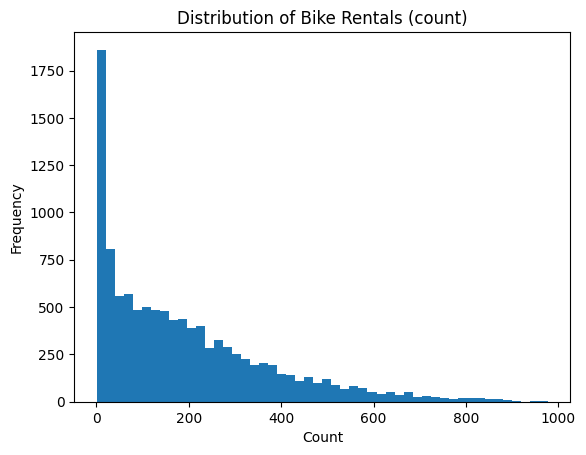

In [27]:
plt.figure()
plt.hist(train["count"], bins=50)
plt.title("Distribution of Bike Rentals (count)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

## **Distribution of Bike Rental Frequency**

Rental Demand is right skewed which is what was expected. The distribution of bike rental demand is right skewed, meaning that most are low to moderate rental counts, while only a small number of periods experience very high demand. Although time is not shown directly in the histogram, this pattern reflects how people rent bikes, where demand spikes occur during peak commuting hours. These high values represent real periods of increased bike usage rather than errors in the data.

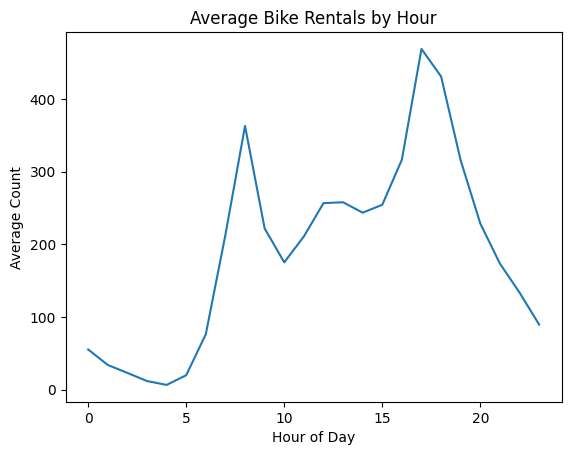

In [28]:
# 2. Average rentals by hour
plt.figure()
train.groupby("hour")["count"].mean().plot()
plt.title("Average Bike Rentals by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Count")
plt.show()

## **Hour of Day**
*   Very low demand 0–5 AM
*   A sharp morning peak around 8–9 AM, people are likely to start their day, morning workouts, or getting the bike to commute to work
*   A dip during midday, people are working. Most rentals probably for leisure
*   An even higher evening peak around 5–6 PM, after work leisure, workout, or commute home
*   Gradual decline after 7 PM, end of the day, mostly for leisure or workout

Strong Predictive Feature

This indicates that bike usage is largely driven by work related travel, with significantly lower demand during overnight and midday periods.





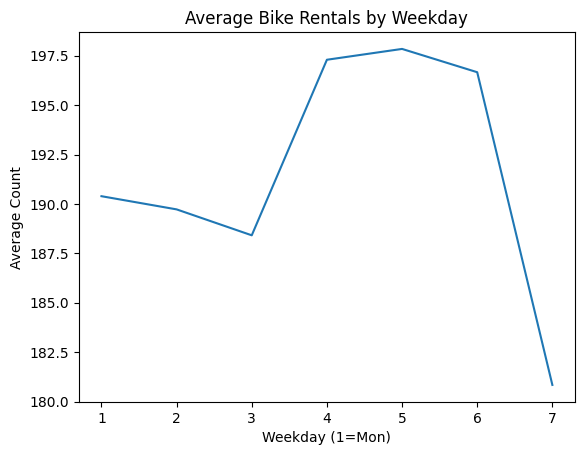

In [29]:
# 3. Average rentals by weekday
plt.figure()
train.groupby("weekday")["count"].mean().plot()
plt.title("Average Bike Rentals by Weekday")
plt.xlabel("Weekday (1=Mon)")
plt.ylabel("Average Count")
plt.show()


## **Days**

Strong Predictive Feature

This shows that average bike rental demand is lowest on Sundays. This is maybe because weekday demand is influenced by commuting to work or school, which is less on Sundays. While some recreational usage still happens, leisure trips tend to be less frequent and more weather dependent than routine weekday travel, resulting in lower overall demand.


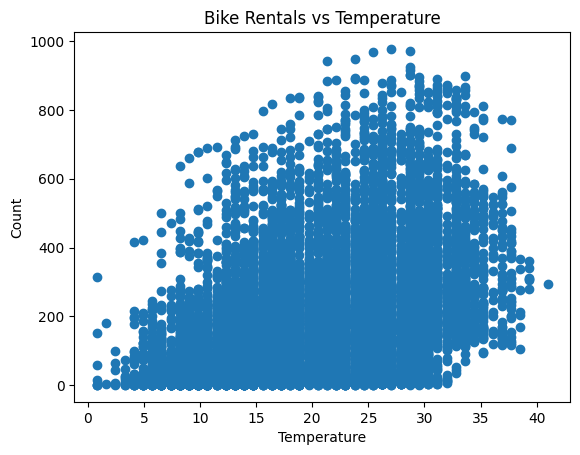

In [30]:
# 4. Rentals vs Temperature
plt.figure()
plt.scatter(train["temp"], train["count"])
plt.title("Bike Rentals vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.show()

## **Temperature**

Moderate Predictive Feature

Clear positive relationship between temperature and rentals. As temperature increases from low to moderate, rentals increase sharply. At very high temperatures, demand plateaus or slightly declines

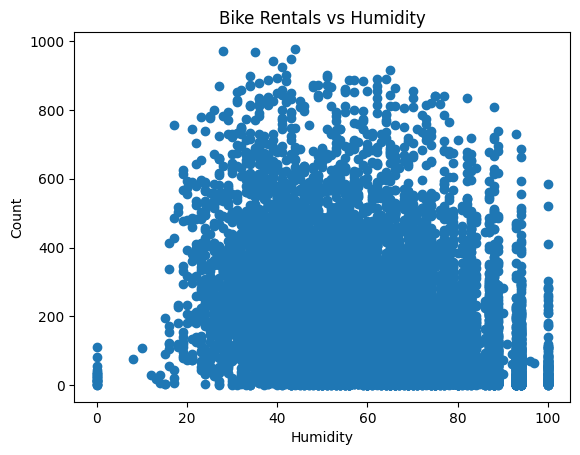

In [31]:
# 5. Rentals vs Humidity
plt.figure()
plt.scatter(train["humidity"], train["count"])
plt.title("Bike Rentals vs Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count")
plt.show()

## **Humidity**

Points are widely dispersed across all humidity levels. High and low rental counts occur at both low and high humidity. There is no strong linear pattern. Whether or not Humidity is high or low, there is always a moderate to high amount of rentals. The higher or lower numbers could be because that amount of humidity does not occur often. Overall, there is no relationship between humidity and Bike Rentals. This feature can be dropped


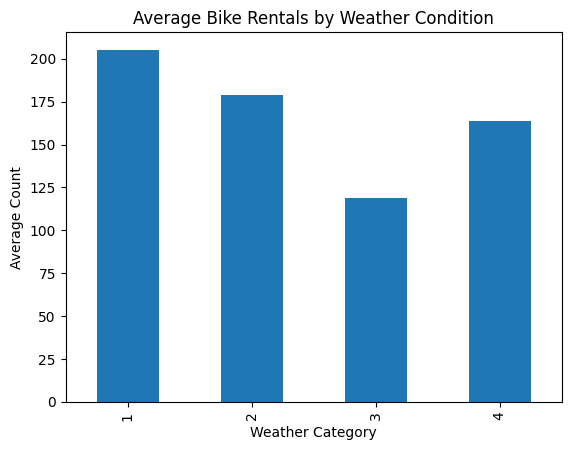

In [32]:
# 6. Average rentals by weather condition
plt.figure()
train.groupby("weather")["count"].mean().plot(kind="bar")
plt.title("Average Bike Rentals by Weather Condition")
plt.xlabel("Weather Category")
plt.ylabel("Average Count")
plt.show()

## **Weather**
*   1: Clear, Few clouds, Partly cloudy, Partly cloudy
*   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
*   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
*   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

Strong Predictive Feature

From the weather we can tell if there is going to be high rentals or not. There will always be rentals, it ranges from ~120-200. The highest amount of rentals are during clear days with no rain or mist. While rain and mist decreases the amount of rain there will be. The weather that plays a factor in the least rentals is snow.Overall, the results confirm that weather is an important categorical predictor of bike rental demand.


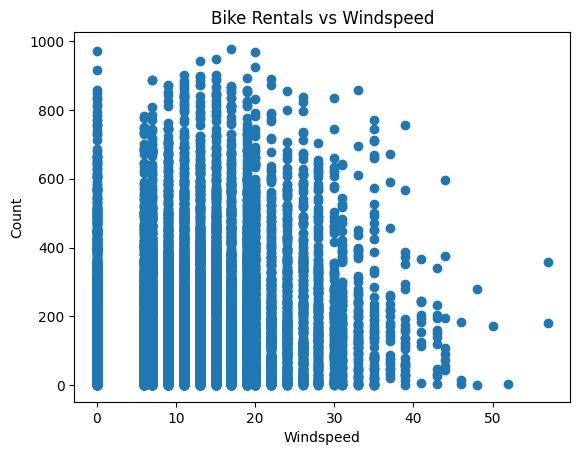

In [33]:
# 4. Rentals vs Windspeed
plt.figure()
plt.scatter(train["windspeed"], train["count"])
plt.title("Bike Rentals vs Windspeed")
plt.xlabel("Windspeed")
plt.ylabel("Count")
plt.show()

## **Windspeed**
Strong Predictive Feature, but can be redundant as the data is similar and directly related to weather. The more dangerous the weather is the less rentals there are. Overall, this feature can be kept or dropped


##  Feature Engineering

***Dropped Columns ***
1.   ***casual and registered*** = Does not influence real world prediction, it is only known after the rental. Casual and Registered also indicates how many are rented, therefore cannot be included in the prediction. It gives the model the answer already
2.   ***atemp*** = about the same as temp, unecessary and redundant feature
3.  ***humidity*** = weak predictive power, there is no correlation between humidity and the number of rentals
4. ***windspeed*** = closely associated with weather, redundant
5. ***datetime*** = changed to hour, weekday, month




In [34]:
train = train.drop(columns=[
    "humidity",
    "windspeed",
    "casual",
    "registered",
    "datetime",
    "atemp"
])


In [35]:
# Define features (X) and target (y)
X = train.drop('count', axis=1)
y = train['count']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
# Categorize columns' dtypes (Numerical vs. Categorical)
# Separates the input features into numeric and categorical columns so they can be prepared correctly for modeling.
cat_like = ["season", "holiday", "workingday", "weather"]
X[cat_like] = X[cat_like].astype("category")

categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns
numeric_cols = X.select_dtypes(include=["number"]).columns

print("\nCategorical columns:")
print(list(categorical_cols))

print("\nNumeric columns:")
print(list(numeric_cols))


Categorical columns:
['season', 'holiday', 'workingday', 'weather']

Numeric columns:
['temp', 'hour', 'month', 'weekday']



# 3) Model Training

### i) Linear Regression

In [37]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Linear Regression
lr_model = LinearRegression()
lr_fit_model = lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_fit_model.predict(X_test_scaled)

# Calculating all metrics
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression: RMSE={lr_rmse:.4f}, R²={lr_r2:.4f}")
linear_regression_results = {'Model':'Linear Regression', 'RMSE':lr_rmse, 'MAE':lr_mae, 'R²':lr_r2}

Linear Regression: RMSE=152.1227, R²=0.2989


### ii) Lasso Regression

In [38]:
lasso_alphas = [0.1, 1.0, 10.0]
lasso_results = []

for alpha in lasso_alphas:
    Lasso_model=Lasso(alpha)
    lm=Lasso_model.fit(X_train_scaled, y_train)
    lasso_model_pred=lm.predict(X_test_scaled)

    lm_mse= mean_squared_error(y_test, lasso_model_pred)
    lm_rmse = np.sqrt(lm_mse)
    lm_mae= mean_absolute_error(y_test, lasso_model_pred)
    lm_r2= r2_score(y_test, lasso_model_pred)
    print(f'Lasso: RMSE={lm_rmse:.4f}, R²={lm_r2:.4f}')
    lasso_results.append({'Model':f'Lasso (α={alpha})', 'RMSE':lm_rmse, 'MAE':lm_mae, 'R²':lm_r2})

print(f"Lasso models trained: {len(lasso_results)}")

Lasso: RMSE=152.1206, R²=0.2989
Lasso: RMSE=152.1464, R²=0.2987
Lasso: RMSE=153.2080, R²=0.2889
Lasso models trained: 3


### iii) Polynomial Regression

In [ ]:
# Polynomial Regression with different degrees
poly_degrees = [2, 3, 4] # Remove 4, if it takes long to run on the system
poly_results = []

for degree in poly_degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train Linear Regression on polynomial features
    poly_model = LinearRegression()
    poly_fit_model = poly_model.fit(X_train_poly, y_train)

    # Make predictions
    poly_pred = poly_fit_model.predict(X_test_poly)

    # Calculate metrics
    poly_mse = mean_squared_error(y_test, poly_pred)
    poly_rmse = np.sqrt(poly_mse)
    poly_mae = mean_absolute_error(y_test, poly_pred)
    poly_r2 = r2_score(y_test, poly_pred)

    print(f'Polynomial (degree={degree}): RMSE={poly_rmse:.4f}, R²={poly_r2:.4f}')

    poly_results.append({
        'Model': f'Polynomial (degree={degree})',
        'RMSE': poly_rmse,
        'MAE': poly_mae,
        'R²': poly_r2
    })

print(f"Polynomial models trained: {len(poly_results)}")

Polynomial (degree=2): RMSE=133.5766, R²=0.4594
Polynomial (degree=3): RMSE=124.8346, R²=0.5279
Polynomial (degree=4): RMSE=118.8804, R²=0.5718
Polynomial models trained: 3


# 4) Model Evaluation

In [40]:
# Combining Results
all_results = [
    linear_regression_results,
    *lasso_results,
    *poly_results
]
results_df = pd.DataFrame(all_results).sort_values('R²', ascending=False)

print("\n- MODEL COMPARISON:")
if results_df is not None:
    print(results_df.to_string(index=False))


- MODEL COMPARISON:
                Model       RMSE        MAE       R²
Polynomial (degree=4) 118.880387  83.122826 0.571831
Polynomial (degree=3) 124.834645  88.259190 0.527866
Polynomial (degree=2) 133.576576  99.393390 0.459426
        Lasso (α=0.1) 152.120566 111.950151 0.298915
    Linear Regression 152.122666 111.949112 0.298896
        Lasso (α=1.0) 152.146392 111.908633 0.298677
       Lasso (α=10.0) 153.208020 113.011092 0.288856


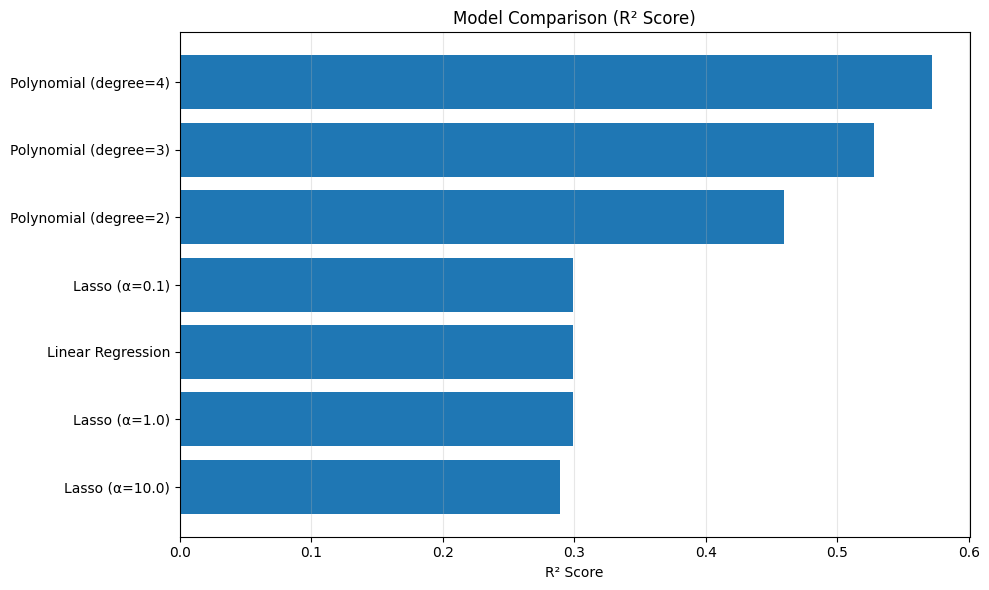

In [41]:
# Sort models by R² (best at top)
results_sorted = results_df.sort_values('R²', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.barh(range(len(results_sorted)), results_sorted['R²'])
plt.yticks(range(len(results_sorted)), results_sorted['Model'])
plt.xlabel('R² Score')
plt.title('Model Comparison (R² Score)')
plt.gca().invert_yaxis()  # Highest R² at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Predicted vs. Actual Plots

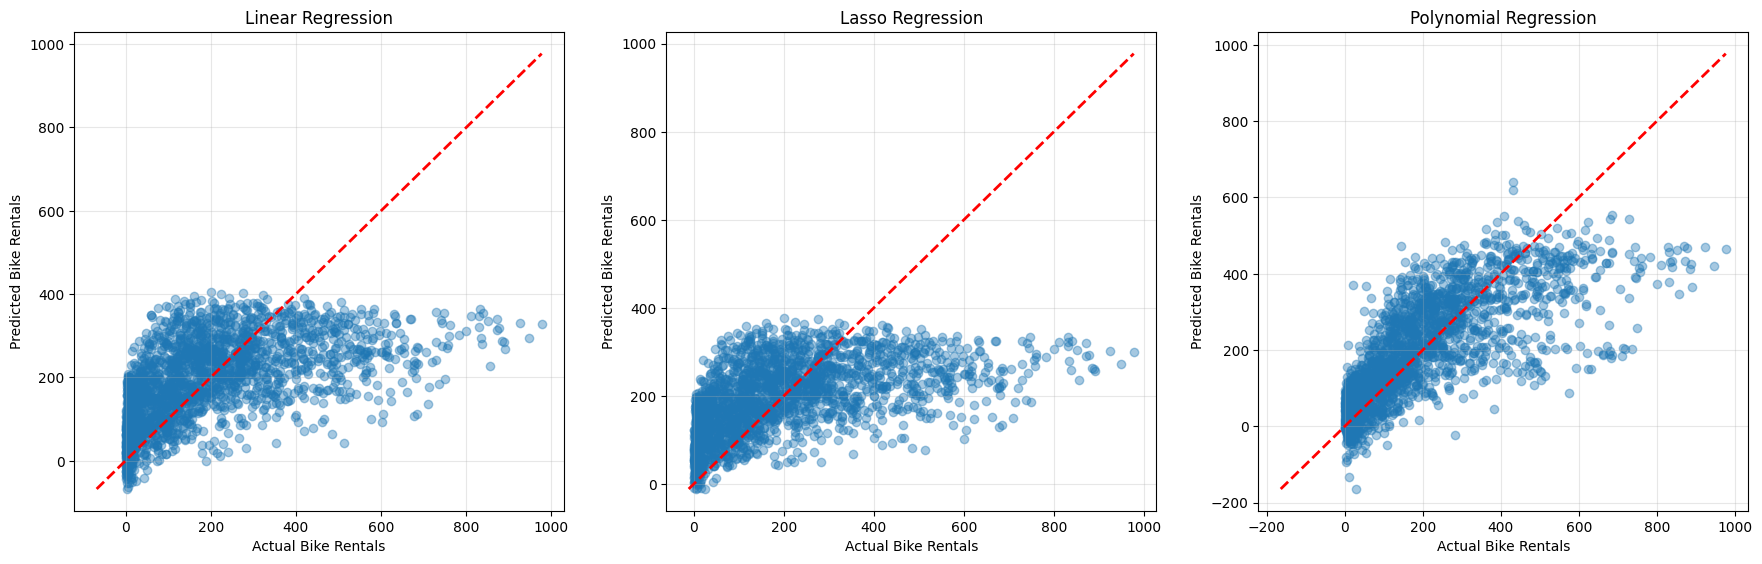

In [42]:
models = {
    "Linear Regression": lr_pred,
    "Lasso Regression": lasso_model_pred,
    "Polynomial Regression": poly_pred
}

plt.figure(figsize=(18, 6))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)

    plt.scatter(y_test, preds, alpha=0.4)

    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())

    # Perfect prediction line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.title(f"{name}")
    plt.xlabel("Actual Bike Rentals")
    plt.ylabel("Predicted Bike Rentals")
    plt.grid(alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()


### Predicted vs. Actual + Residual Plots (Best Model Only)

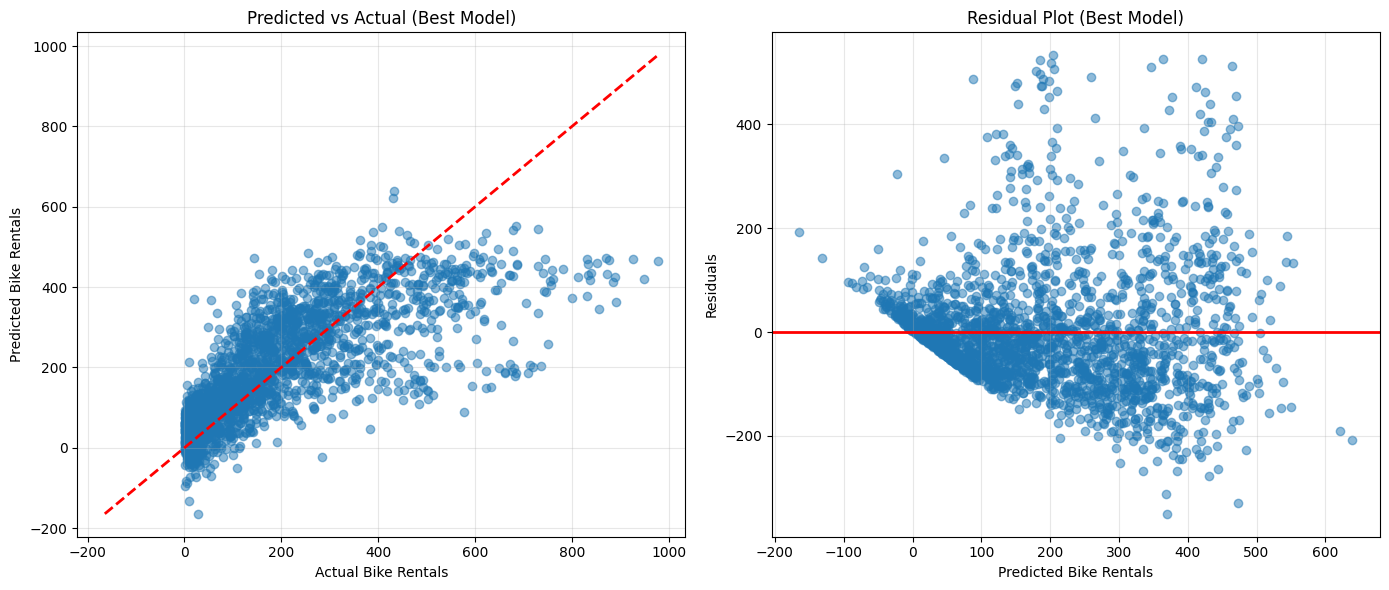

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# -----------------------------
# Predicted vs Actual Plot
# -----------------------------
ax1.scatter(y_test, poly_pred, alpha=0.5)

min_val = min(y_test.min(), poly_pred.min())
max_val = max(y_test.max(), poly_pred.max())

# Perfect prediction line
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_xlabel('Actual Bike Rentals')
ax1.set_ylabel('Predicted Bike Rentals')
ax1.set_title('Predicted vs Actual (Best Model)')
ax1.grid(True, alpha=0.3)

# -----------------------------
# Residual Plot
# -----------------------------
residuals = y_test - poly_pred

ax2.scatter(poly_pred, residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linewidth=2)

ax2.set_xlabel('Predicted Bike Rentals')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot (Best Model)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance


📊 Feature Importance (Top 10):
                        Feature  Coefficient  Abs_Coefficient
season workingday month weekday   772.610792       772.610792
        season workingday month  -616.683616       616.683616
           season weather month   424.178054       424.178054
     workingday month^2 weekday  -402.673726       402.673726
    season^2 workingday weekday  -382.936977       382.936977
                   season month  -327.592951       327.592951
         season month weekday^2   321.098520       321.098520
             workingday month^2   308.259847       308.259847
         holiday temp weekday^2  -286.297698       286.297698
              season temp month   275.752680       275.752680


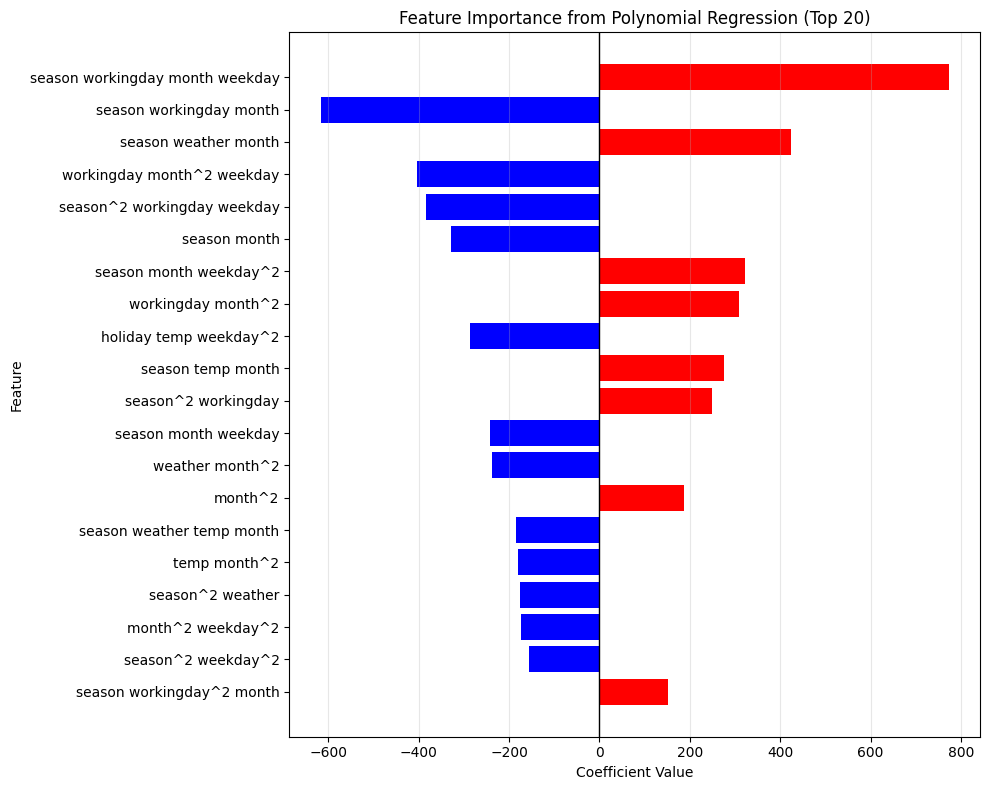

In [44]:
# Get feature names after polynomial transformation (use the ORIGINAL column names)
feature_names_poly = poly.get_feature_names_out(X_train.columns)

# Create DataFrame with features and coefficients from poly_model
feature_importance = pd.DataFrame({
    'Feature': feature_names_poly,
    'Coefficient': poly_model.coef_
})

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\n📊 Feature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance (Top N only)
TOP_N = 20
top_feats = feature_importance.head(TOP_N).copy()

plt.figure(figsize=(10, 8))

# Color positive vs negative coefficients
colors = ['red' if c > 0 else 'blue' for c in top_feats['Coefficient']]

plt.barh(top_feats['Feature'][::-1], top_feats['Coefficient'][::-1], color=colors[::-1])

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Feature Importance from Polynomial Regression (Top {TOP_N})')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# Analysis